# 👾 PixelCNN - 케라스

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/02_pixelcnn/pixelcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks
    # output 디렉토리를 만듭니다.
    !mkdir output

--2023-11-09 07:23:51--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-11-09 07:23:51 (34.5 MB/s) - ‘utils.py’ saved [771/771]



이 노트북에서는 패션 MNIST 데이터셋에서 PixelCNN을터 훈련합니다.

이 코드는 케라스 웹 사이트에 있는 ADMoreau가 만든 훌륭한 [PixelCNN 튜토리얼](https://keras.io/examples/generative/pixelcnn/)을 참고했습니다.

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. 데이터 준비 <a name="prepare"></a>

In [4]:
# 데이터 로드
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
# 데이터 전처리
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

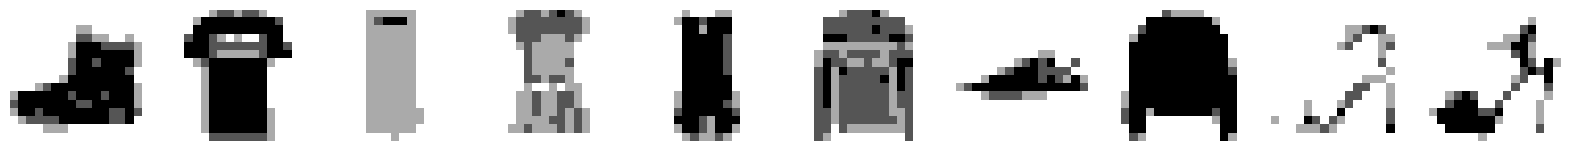

In [6]:
# 훈련 세트에 있는 샘플 출력하기
display(input_data)

## 2. PixelCNN 만들기

In [7]:
# 첫 번째 층은 PixelCNN 층입니다.
# 이 층은 마스킹을 가진 2D 합성곱 층입니다.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # conv2d 층을 만들고 커널 변수를 초기화합니다.
        self.conv.build(input_shape)
        # 초기화된 커널을 사용해 마스크를 만듭니다.
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [8]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [9]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2  (None, 16, 16, 128)       6400      
 D)                                                              
                                                                 
 residual_block (ResidualBl  (None, 16, 16, 128)       53504     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_2 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                      

## 3. PixelCNN 훈련하기 <a name="train"></a>

In [10]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [11]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해
            generated_images = self.generate(temperature=1.0)
            display(
                generated_images,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/150
  5/469 [..............................] - ETA: 17s - loss: 1.3640

469/469 [==============================] - ETA: 0s - loss: 0.4932
Saved to ./output/generated_img_000.png


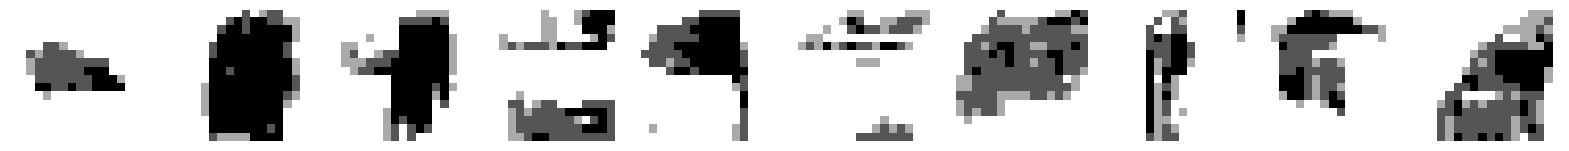

469/469 [==============================] - 43s 60ms/step - loss: 0.4932
Epoch 2/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3967
Epoch 3/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3856
Epoch 4/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3796
Epoch 5/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3763
Epoch 6/150
469/469 [==============================] - 15s 32ms/step - loss: 0.3729
Epoch 7/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3702
Epoch 8/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3679
Epoch 9/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3655
Epoch 10/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3634
Epoch 11/150
467/469 [============================>.] - ETA: 0s - loss: 0.3616
Saved to ./output/generated_img_010.png


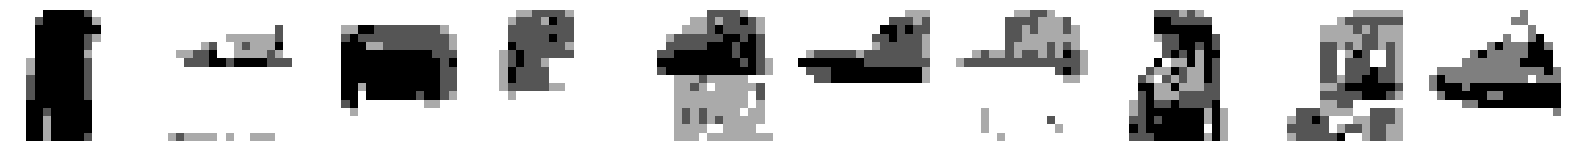

469/469 [==============================] - 27s 58ms/step - loss: 0.3616
Epoch 12/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3592
Epoch 13/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3578
Epoch 14/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3561
Epoch 15/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3549
Epoch 16/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3534
Epoch 17/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3523
Epoch 18/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3514
Epoch 19/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3502
Epoch 20/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3495
Epoch 21/150
467/469 [============================>.] - ETA: 0s - loss: 0.3485
Saved to ./output/generated_img_020.png


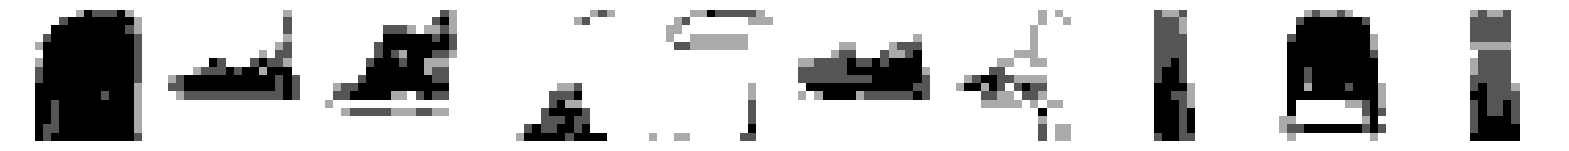

469/469 [==============================] - 28s 59ms/step - loss: 0.3485
Epoch 22/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3481
Epoch 23/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3472
Epoch 24/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3463
Epoch 25/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3456
Epoch 26/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3451
Epoch 27/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3446
Epoch 28/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3440
Epoch 29/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3433
Epoch 30/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3430
Epoch 31/150
469/469 [==============================] - ETA: 0s - loss: 0.3424
Saved to ./output/generated_img_030.png


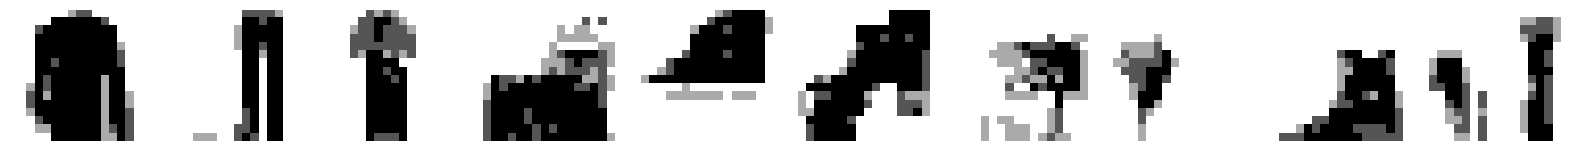

469/469 [==============================] - 27s 58ms/step - loss: 0.3424
Epoch 32/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3416
Epoch 33/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3414
Epoch 34/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3410
Epoch 35/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3406
Epoch 36/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3400
Epoch 37/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3397
Epoch 38/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3395
Epoch 39/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3389
Epoch 40/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3387
Epoch 41/150
469/469 [==============================] - ETA: 0s - loss: 0.3384
Saved to ./output/generated_img_040.png


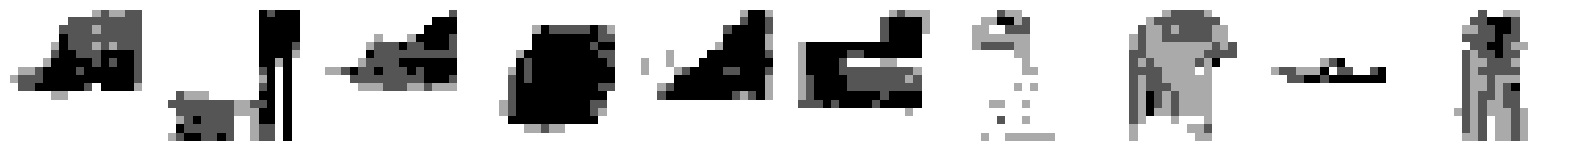

469/469 [==============================] - 28s 59ms/step - loss: 0.3384
Epoch 42/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3380
Epoch 43/150
469/469 [==============================] - 14s 30ms/step - loss: 0.3376
Epoch 44/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3375
Epoch 45/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3371
Epoch 46/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3367
Epoch 47/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3365
Epoch 48/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3362
Epoch 49/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3359
Epoch 50/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3356
Epoch 51/150
469/469 [==============================] - ETA: 0s - loss: 0.3353
Saved to ./output/generated_img_050.png


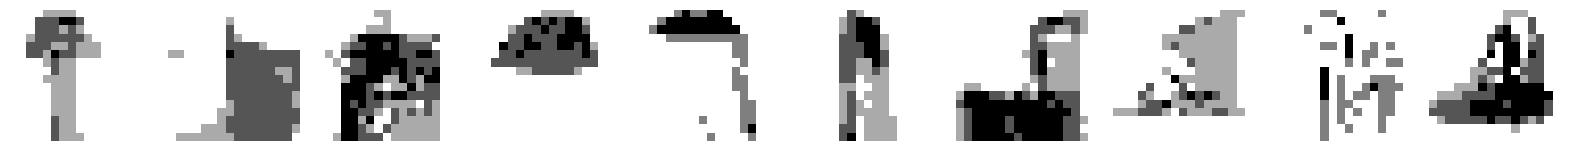

469/469 [==============================] - 28s 60ms/step - loss: 0.3353
Epoch 52/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3351
Epoch 53/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3349
Epoch 54/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3347
Epoch 55/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3344
Epoch 56/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3342
Epoch 57/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3340
Epoch 58/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3339
Epoch 59/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3334
Epoch 60/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3331
Epoch 61/150
469/469 [==============================] - ETA: 0s - loss: 0.3334
Saved to ./output/generated_img_060.png


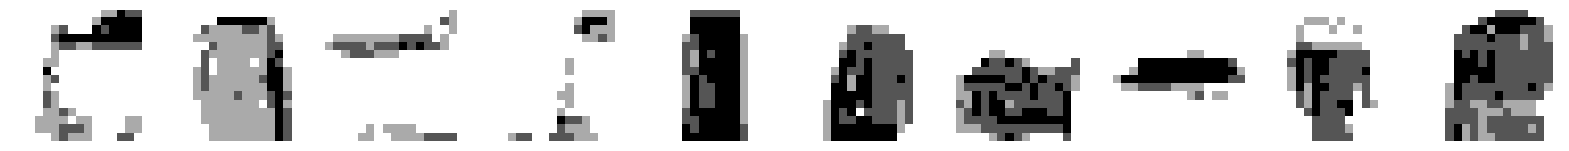

469/469 [==============================] - 27s 58ms/step - loss: 0.3334
Epoch 62/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3329
Epoch 63/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3327
Epoch 64/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3326
Epoch 65/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3324
Epoch 66/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3320
Epoch 67/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3320
Epoch 68/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3320
Epoch 69/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3317
Epoch 70/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3316
Epoch 71/150
469/469 [==============================] - ETA: 0s - loss: 0.3313
Saved to ./output/generated_img_070.png


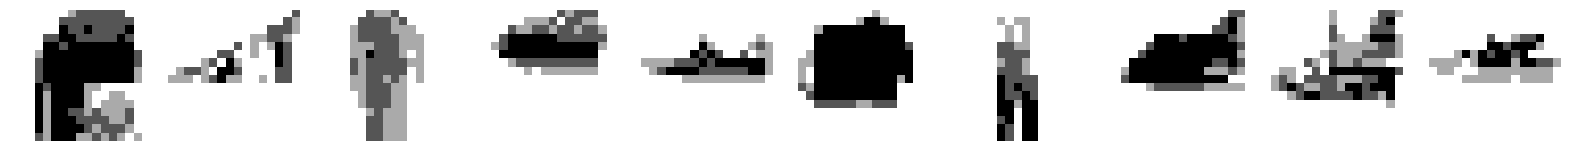

469/469 [==============================] - 28s 59ms/step - loss: 0.3313
Epoch 72/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3311
Epoch 73/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3311
Epoch 74/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3308
Epoch 75/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3308
Epoch 76/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3305
Epoch 77/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3304
Epoch 78/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3303
Epoch 79/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3302
Epoch 80/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3301
Epoch 81/150
469/469 [==============================] - ETA: 0s - loss: 0.3299
Saved to ./output/generated_img_080.png


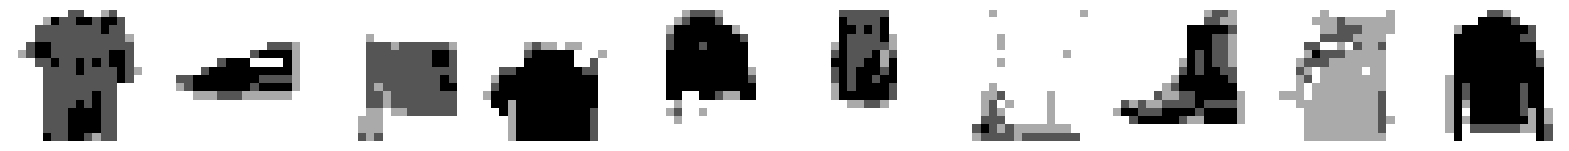

469/469 [==============================] - 27s 57ms/step - loss: 0.3299
Epoch 82/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3296
Epoch 83/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3295
Epoch 84/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3294
Epoch 85/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3292
Epoch 86/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3293
Epoch 87/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3291
Epoch 88/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3290
Epoch 89/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3288
Epoch 90/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3287
Epoch 91/150
469/469 [==============================] - ETA: 0s - loss: 0.3286
Saved to ./output/generated_img_090.png


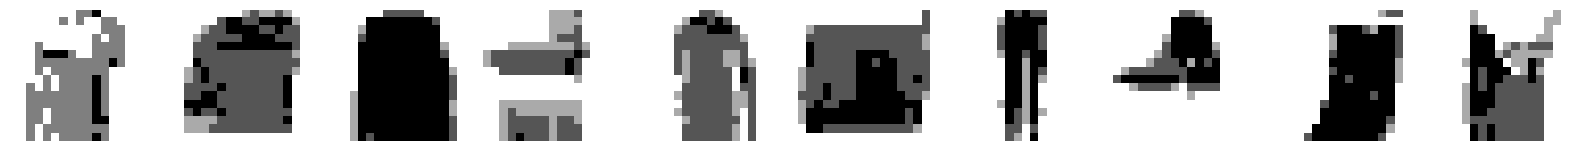

469/469 [==============================] - 27s 58ms/step - loss: 0.3286
Epoch 92/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3285
Epoch 93/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3283
Epoch 94/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3282
Epoch 95/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3281
Epoch 96/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3279
Epoch 97/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3281
Epoch 98/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3278
Epoch 99/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3275
Epoch 100/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3276
Epoch 101/150
467/469 [============================>.] - ETA: 0s - loss: 0.3274
Saved to ./output/generated_img_100.png


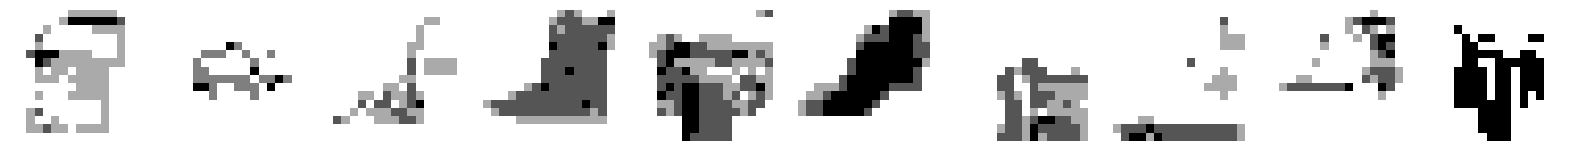

469/469 [==============================] - 27s 57ms/step - loss: 0.3274
Epoch 102/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3273
Epoch 103/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3273
Epoch 104/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3271
Epoch 105/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3270
Epoch 106/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3269
Epoch 107/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3269
Epoch 108/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3267
Epoch 109/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3266
Epoch 110/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3266
Epoch 111/150
469/469 [==============================] - ETA: 0s - loss: 0.3263
Saved to ./output/generated_img_110.png


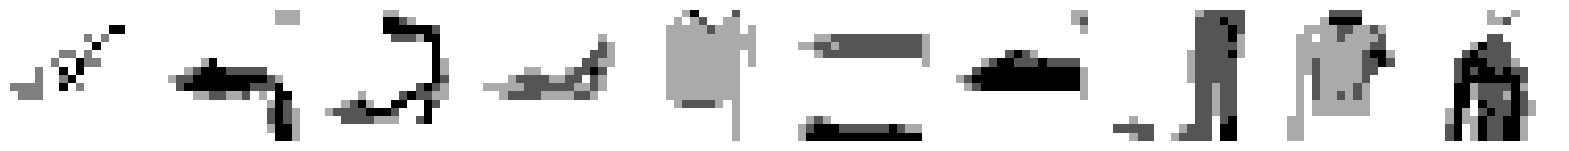

469/469 [==============================] - 26s 56ms/step - loss: 0.3263
Epoch 112/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3264
Epoch 113/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3262
Epoch 114/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3262
Epoch 115/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3261
Epoch 116/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3261
Epoch 117/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3258
Epoch 118/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3259
Epoch 119/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3257
Epoch 120/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3258
Epoch 121/150
467/469 [============================>.] - ETA: 0s - loss: 0.3256
Saved to ./output/generated_img_120.png


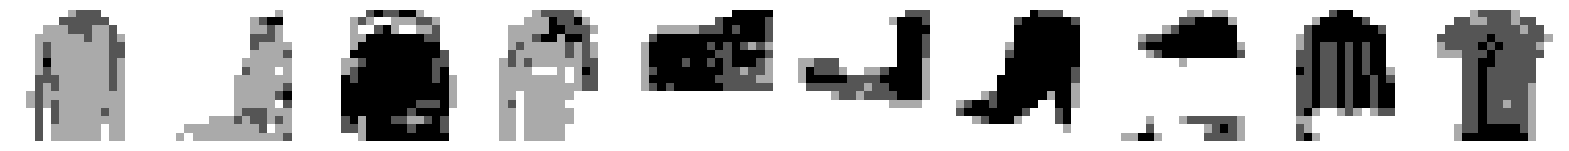

469/469 [==============================] - 27s 58ms/step - loss: 0.3256
Epoch 122/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3254
Epoch 123/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3253
Epoch 124/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3253
Epoch 125/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3251
Epoch 126/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3253
Epoch 127/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3252
Epoch 128/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3249
Epoch 129/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3249
Epoch 130/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3249
Epoch 131/150
469/469 [==============================] - ETA: 0s - loss: 0.3249
Saved to ./output/generated_img_130.png


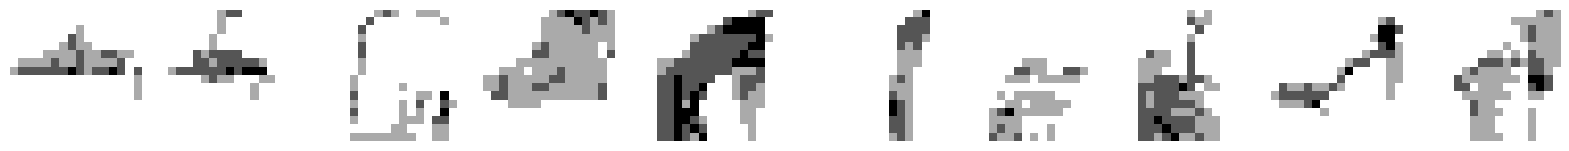

469/469 [==============================] - 26s 56ms/step - loss: 0.3249
Epoch 132/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3246
Epoch 133/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3248
Epoch 134/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3245
Epoch 135/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3245
Epoch 136/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3246
Epoch 137/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3244
Epoch 138/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3243
Epoch 139/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3243
Epoch 140/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3242
Epoch 141/150
469/469 [==============================] - ETA: 0s - loss: 0.3241
Saved to ./output/generated_img_140.png


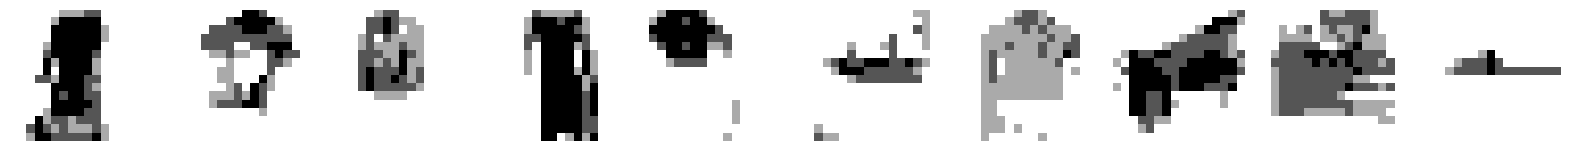

469/469 [==============================] - 27s 59ms/step - loss: 0.3241
Epoch 142/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3241
Epoch 143/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3241
Epoch 144/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3239
Epoch 145/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3238
Epoch 146/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3237
Epoch 147/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3238
Epoch 148/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3236
Epoch 149/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3235
Epoch 150/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3236


In [12]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. 이미지 생성하기 <a name="generate"></a>

In [13]:
generated_images = img_generator_callback.generate(temperature=1.0)

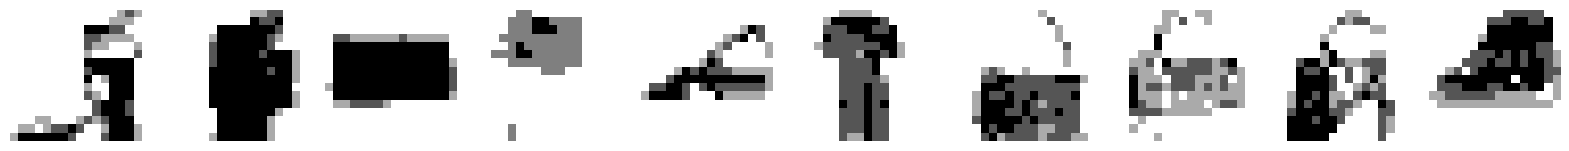

In [14]:
display(generated_images)